# Process KNMI data for forcing analysis

In this Notebook, the downloaded precipitation and potential evaporation data of the KNMI Maastricht weather station are processed. The data is made ready for the analysis. The potential evaporation data is used as forcing of the hydrological models and is converted to raster data.

## Import required packages 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

## Precipitation

### Load in the hourly data of the Maastricht weather station

The KNMI data of the Maastricht weather station is loaded. It consists of two files, each for a 10 year time period

In [2]:
folder = r"C:\Users\924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Precipitation - NRR"

In [3]:
data1 = pd.read_csv(f'{folder}/uurgeg_380_2011-2020.txt',skiprows=31,index_col=[0],skipinitialspace=True,delimiter=',')
data2 = pd.read_csv(f'{folder}/uurgeg_380_2021-2030.txt',skiprows=31,index_col=[0],skipinitialspace=True,delimiter=',')

### Convert precipitation to mm and remove the negative values 

The unit of the precipitation is 0.1 mm, so it should be converted to mm by dividing the values by 10. Also the negative values are removed, which is physical not possible, and are replaced by zeros

In [4]:
data1['RH'] = data1['RH']/10
data1.loc[data1.RH < 0, 'RH'] = 0

data2['RH'] = data2['RH']/10
data2.loc[data2.RH < 0, 'RH'] = 0

### Create a datetime column based on the date and hour information given in the files

The given date information is given in two columns of YYYYMMDD and HH. Those columns are combined and converted to datetime values. This makes it possible to combine the files of the two data periods

In [5]:
# Convert 'YYYYMMDD' and 'HH' columns to strings if they are not already.
data1['YYYYMMDD'] = data1['YYYYMMDD'].astype(str)
data1['HH'] = data1['HH'].astype(int)  # Convert 'HH' to integer

# Handle "24" hour by incrementing the date and setting hour to "00"
mask = data1['HH'] == 24
data1.loc[mask, 'HH'] = 0
data1.loc[mask, 'YYYYMMDD'] = (pd.to_datetime(data1.loc[mask, 'YYYYMMDD'], format='%Y%m%d') + pd.DateOffset(days=1)).dt.strftime('%Y%m%d')

# Combine 'YYYYMMDD' and 'HH' columns into a single datetime column
data1['Datetime'] = pd.to_datetime(data1['YYYYMMDD'] + data1['HH'].apply(lambda x: str(x).zfill(2)), format='%Y%m%d%H', errors='coerce')

# Handle the last hour of the month
mask_last_hour_last_day = (data1['HH'] == 0) & (data1['Datetime'].dt.is_month_end)
data1.loc[mask_last_hour_last_day, 'Datetime'] = data1.loc[mask_last_hour_last_day, 'Datetime'] + pd.DateOffset(days=1)

# Zero-pad the 'HH' column
data1['HH'] = data1['HH'].apply(lambda x: str(x).zfill(2))

# The 'Datetime' column will contain the combined datetime values.

In [6]:
# Convert 'YYYYMMDD' and 'HH' columns to strings if they are not already.
data2['YYYYMMDD'] = data2['YYYYMMDD'].astype(str)
data2['HH'] = data2['HH'].astype(int)  # Convert 'HH' to integer

# Handle "24" hour by incrementing the date and setting hour to "00"
mask = data2['HH'] == 24
data2.loc[mask, 'HH'] = 0
data2.loc[mask, 'YYYYMMDD'] = (pd.to_datetime(data2.loc[mask, 'YYYYMMDD'], format='%Y%m%d') + pd.DateOffset(days=1)).dt.strftime('%Y%m%d')

# Combine 'YYYYMMDD' and 'HH' columns into a single datetime column
data2['Datetime'] = pd.to_datetime(data2['YYYYMMDD'] + data2['HH'].apply(lambda x: str(x).zfill(2)), format='%Y%m%d%H', errors='coerce')

# Handle the last hour of the month
mask_last_hour_last_day = (data2['HH'] == 0) & (data2['Datetime'].dt.is_month_end)
data2.loc[mask_last_hour_last_day, 'Datetime'] = data2.loc[mask_last_hour_last_day, 'Datetime'] + pd.DateOffset(days=1)

# Zero-pad the 'HH' column
data2['HH'] = data2['HH'].apply(lambda x: str(x).zfill(2))

# The 'Datetime' column will contain the combined datetime values.

### Create dataframes of the precipitation values

The precipitation data consists of two data periods, which have to be combined.

#### Dataframe of the first data period

In [7]:
x = pd.DataFrame()

x['Datetime'] = data1.Datetime.values
x['Precipitation'] = data1.RH.values
x.set_index('Datetime',inplace=True)
x = x.loc['2019-01-01':]

#### Dataframe of the second data period

In [8]:
y = pd.DataFrame()

y['Datetime'] = data2.Datetime.values
y['Precipitation'] = data2.RH.values
y.set_index('Datetime', inplace=True)
y = y.loc['2021-01-01':'2022-04-01']

C:\Users\924259\AppData\Local\Temp\ipykernel_5816\1492467529.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  y = y.loc['2021-01-01':'2022-04-01']


### Combine the two data periods

In [9]:
maastricht = pd.concat([x,y])

### Check data

<Axes: xlabel='Datetime'>

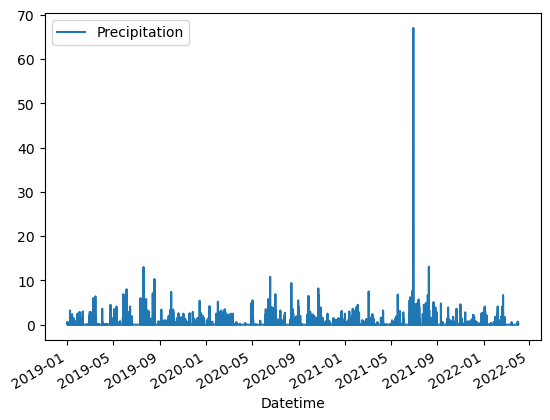

In [11]:
maastricht.plot()

### Convert to UTC timezone

The KNMI data is provided in UTC +1, so to be consistent with the timeperiod, the timeperiod should be changed to UTC +0 by subtracting 1 hour of the index

In [12]:
maastricht.index = maastricht.index - timedelta(hours=1)

### Select correct time frame

In [13]:
maastricht = maastricht['2019-01-01':'2022-04-01 00:00:00']

### Check precipitation data

In [14]:
maastricht

,Precipitation
Datetime,
2019-01-01 00:00:00,0.0
2019-01-01 01:00:00,0.0
2019-01-01 02:00:00,0.1
2019-01-01 03:00:00,0.2
2019-01-01 04:00:00,0.0
...,...
2022-03-31 20:00:00,0.0
2022-03-31 21:00:00,0.0
2022-03-31 22:00:00,0.0


### Save the Maastricht precipitation data

In [15]:
maastricht.to_csv(f'{folder}/Maastricht_Precipitation.csv')

## Evaporation

### Load the potential evaporation data

In [15]:
evap = pd.read_csv(f'{folder}/result.txt',skiprows=8,index_col=[0],skipinitialspace=True,delimiter=',')

### Convert to mm

The potential evaporation is given in 0.1 mm, so it should be converted to mm by dividing the values by 10

In [16]:
evap['EV24'] = evap['EV24']/10

### Set the date index as datetimes

In [17]:
evap.set_index('YYYYMMDD',inplace = True)
evap.index = pd.to_datetime(evap.index, format='%Y%m%d')
evap.index = evap.index.strftime('%Y-%m-%d')
evap.index = pd.to_datetime(evap.index)

### Check data

<Axes: xlabel='YYYYMMDD'>

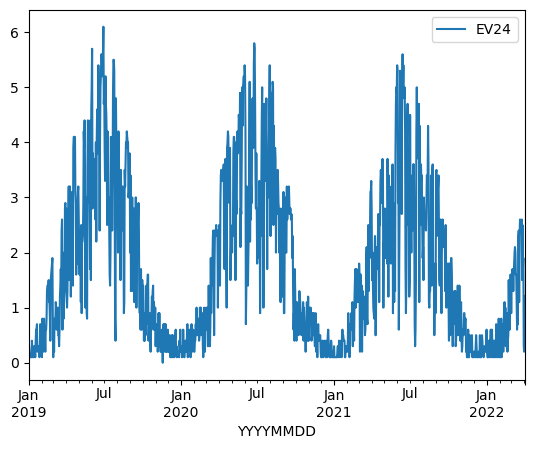

In [19]:
evap.plot()

### Convert the daily data to hourly data

The hourly data has the same amount of potential evaporation over the day

In [20]:
evap_hourly = evap.resample('H').asfreq().ffill()
evap_hourly = evap_hourly/24
evap_hourly = evap_hourly['2019-01-01':'2022-04-01 00:00:00']

### Check data

<Axes: xlabel='YYYYMMDD'>

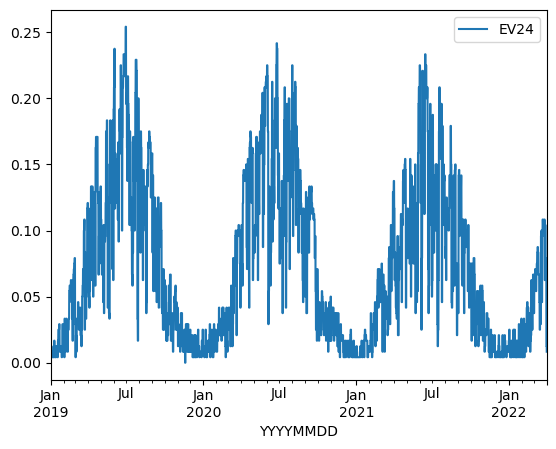

In [21]:
evap_hourly.plot()

In [22]:
evap_hourly

,EV24
YYYYMMDD,
2019-01-01 00:00:00,0.004167
2019-01-01 01:00:00,0.004167
2019-01-01 02:00:00,0.004167
2019-01-01 03:00:00,0.004167
2019-01-01 04:00:00,0.004167
...,...
2022-03-31 20:00:00,0.012500
2022-03-31 21:00:00,0.012500
2022-03-31 22:00:00,0.012500


### Create rasterdata

In [24]:
y = np.array([50.9175,50.909167,50.900833,50.8925,50.884167,50.875833,50.8675,50.859167,50.850833,50.8425,50.834167,
              50.825833,50.8175,50.809167,50.800833,50.7925,50.784167,50.775833,50.7675,50.759167,50.750833,50.7425,
              50.734167,50.725833,50.7175,50.709167,50.700833,50.6925,50.684167,50.675833,50.6675,50.659167,50.650833])
x = np.array([5.718333,5.726667,5.735,5.743333,5.751667,5.76,5.768333,5.776667,5.785,5.793333,5.801667,5.81,5.818333,
              5.826667,5.835,5.843333,5.851667,5.86,5.868333,5.876667,5.885,5.893333,5.901667,5.91,5.918333,5.926667,
              5.935,5.943333,5.951667,5.96,5.968333,5.976667,5.985,5.993333,6.001667,6.01,6.018333,6.026667,6.035,
              6.043333,6.051667,6.06,6.068333,6.076667,6.085,6.093333,6.101667,6.11,6.118333,6.126667])

time = np.array(evap_hourly.index)

coords = {'time': time, 'y': y, 'x': x}
dims = ['time', 'y', 'x']

data = np.zeros((len(time),len(y),len(x))) 

In [25]:
ds = xr.Dataset({'potential_evaporation': (dims, data)}, coords=coords,attrs={'units': 'mm/h'} )
evap_hourly_array = evap_hourly.to_numpy().reshape((len(time), 1, 1))
ds['potential_evaporation'][:] = evap_hourly_array

In [26]:
ds

<xarray.Dataset>
Dimensions:                (time: 28465, y: 33, x: 50)
Coordinates:
  * time                   (time) datetime64[ns] 2019-01-01 ... 2022-04-01
  * y                      (y) float64 50.92 50.91 50.9 ... 50.67 50.66 50.65
  * x                      (x) float64 5.718 5.727 5.735 ... 6.11 6.118 6.127
Data variables:
    potential_evaporation  (time, y, x) float64 0.004167 0.004167 ... 0.008333
Attributes:
    units:    mm/h

### Save the Maastricht potential evaporation data

#### Hourly data

In [23]:
evap_hourly.to_csv(f'{folder}/Maastricht_Evaporation.csv')

#### Daily data

In [24]:
evap.to_csv(f'{folder}/Maastricht_daily.csv')

#### Hourly raster data

In [27]:
ds.to_netcdf(r"C:\Users\924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Potential Evaporation and Temperature - ERA5/Maastricht_radar.nc")